# Identification of Gout Flares using Chief Complaint text using NLP in Machine Learning

In [93]:
#pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
#importing the necessary libraries
import nltk
import spacy
import re
import sklearn
import contractions
import pandas as pd

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from collections import Counter
from imblearn.over_sampling import SMOTE
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from contractions import fix
from spellchecker import SpellChecker
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import roc_curve, auc

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tinkuacchu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tinkuacchu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
#reading the dataset here \t is used to seperate the columns based on the dataset
complaints = pd.read_csv("GOUT-CC-2020-CORPUS-REDACTED.tsv", sep="\t")

In [5]:
#Gives information about the columns such as constraint, datatype
complaints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8137 entries, 0 to 8136
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Chief Complaint  8137 non-null   object
 1   Predict          8137 non-null   object
 2   Consensus        8137 non-null   object
dtypes: object(3)
memory usage: 190.8+ KB


In [6]:
complaints.head()

,Chief Complaint,Predict,Consensus
0,"""I dont know whats going on with my head, its ...",N,-
1,"""i've been depressed for a few weeks now, i'm ...",N,-
2,"Altercation while making arrest, c/o R hand pa...",N,N
3,Cut on L upper thigh wtih saw. Bleeding contro...,N,N
4,"Dysuria x1 week. hx: hysterectomy, gerd, bipolar",N,-


In [7]:
#Used to count the different values present in Predict column of complaint dataframe
complaints['Predict'].value_counts()

Predict
N    7992
U     129
Y      14
-       2
Name: count, dtype: int64

In [8]:
#Used to count the different values present in Consensus column of complaint dataframe
complaints['Consensus'].value_counts()

Consensus
-    7873
N     232
Y      25
U       7
Name: count, dtype: int64

In [9]:
#This gives the sum of null values in each column
complaints.isnull().sum()

Chief Complaint    0
Predict            0
Consensus          0
dtype: int64

In [10]:
#creating a new column for word count
word_count_df = pd.DataFrame()

# Add a column for word count
word_count_df['word_count'] = complaints['Chief Complaint'].apply(lambda x: len(x.split()))

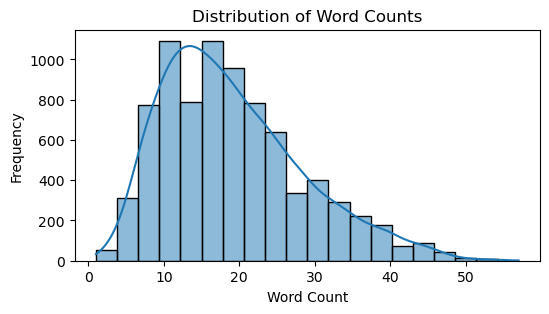

In [11]:
# Plot the distribution for word count
plt.figure(figsize=(6,3))
sns.histplot(word_count_df['word_count'], bins=20, kde=True)
plt.title('Distribution of Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

In [12]:
#Drop the duplicate rows present in the dataframe
complaints.drop_duplicates(inplace=True)

/var/folders/vt/gsz9r5ls2bbdhx12jrgnq06r0000gn/T/ipykernel_27531/1491923888.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=complaints["Predict"], palette="Set2")


Text(0, 0.5, 'count')

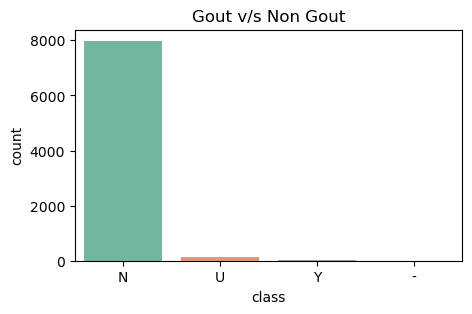

In [13]:
#plot the distribution for predict column ( i.e yes/no)
plt.figure(figsize=(5,3))
sns.countplot(x=complaints["Predict"], palette="Set2")
plt.title('Gout v/s Non Gout')
plt.xlabel('class')
plt.ylabel('count')

In [14]:
#count bigram pairs of consecutive words
vectorizer = CountVectorizer(ngram_range=(2,2) , stop_words="english")
# Filter the DataFrame
filtered_complaints = complaints[complaints['Predict'] != 'N']

# Apply the vectorizer to the filtered 'Chief Complaint' column
X = vectorizer.fit_transform(filtered_complaints['Chief Complaint'])
bigramFrequency = dict(zip(vectorizer.get_feature_names_out(), X.toarray().sum(axis = 0)))

In [15]:
sortedBigrams = sorted(bigramFrequency.items(), key=lambda x:x[1], reverse=True)[:20]
print(sortedBigrams)

[('knee pain', 35), ('pain swelling', 27), ('foot pain', 23), ('denies injury', 17), ('denies trauma', 16), ('hip pain', 14), ('right knee', 12), ('pt states', 10), ('ankle pain', 9), ('left foot', 9), ('pmhx htn', 9), ('pmh htn', 8), ('hx htn', 7), ('pain weeks', 7), ('right foot', 7), ('big toe', 6), ('leg pain', 6), ('pain days', 6), ('pain x3', 6), ('pmh denies', 6)]


In [16]:
keyword = set()
for Bigram, count in sortedBigrams:
    words = Bigram.split()
    keyword.update(words)

keyword = list(keyword)

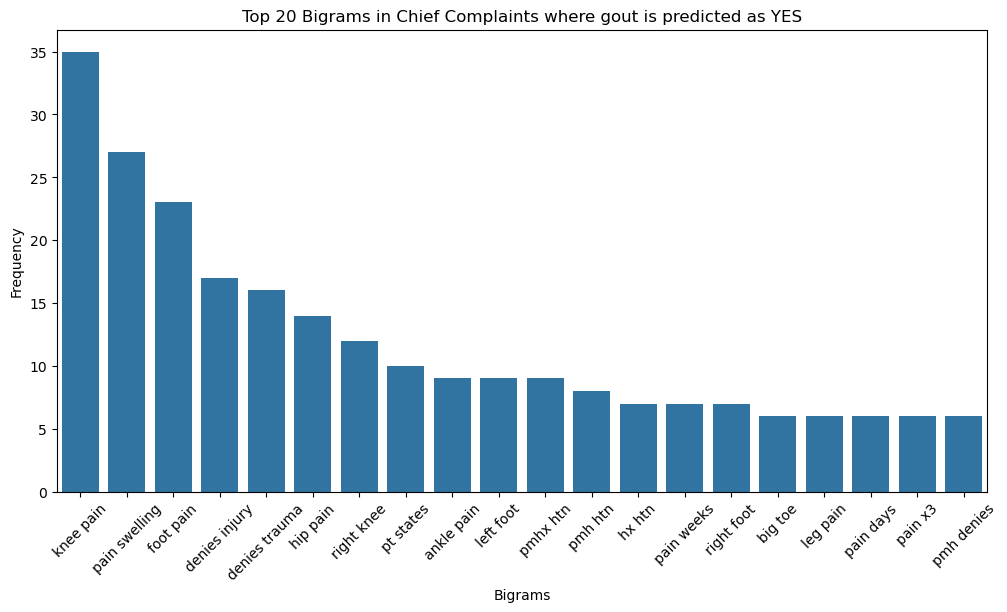

In [17]:
plt.figure(figsize=(12, 6))
sns.barplot(x=[b[0] for b in sortedBigrams], y=[b[1] for b in sortedBigrams])
plt.xticks(rotation=45)
plt.title("Top 20 Bigrams in Chief Complaints where gout is predicted as YES")
plt.xlabel("Bigrams")
plt.ylabel("Frequency")
plt.show()

In [18]:
"""def find_redacted(text):
    redacted_pattern = r"<<(.*?)>>"
    return re.findall(redacted_pattern, text) if isinstance(text, str) else []

# Apply the function to each row in the chief complaint column
redactedText = complaints["Chief Complaint"].apply(find_redacted)"""


'def find_redacted(text):\n    redacted_pattern = r"<<(.*?)>>"\n    return re.findall(redacted_pattern, text) if isinstance(text, str) else []\n\n# Apply the function to each row in the chief complaint column\nredactedText = complaints["Chief Complaint"].apply(find_redacted)'

In [19]:
"""redactedText.value_counts()"""

'redactedText.value_counts()'

# 1. Data Preprocessing

# 1.1 Handling Abbrievations

In [20]:
#Regular Expression For detecting Abbrivations

abbrievationPattern = r'\b(?:[A-Za-z]{2,}[A-Z0-9]+[A-Za-z0-9]*|[A-Za-z]+/[A-Za-z]+)\b'

In [21]:
#This function is used to find the abbrievations
def findAbbrievation(text):
    regex = re.findall(abbrievationPattern, str(text))
    print(regex)
    return regex

In [22]:
# the apply function implements the functions and returns abbrievations or shortforms of texts present in each line
abbrievation = complaints["Chief Complaint"].apply(findAbbrievation)  

['c/o', 'PMHX', 'PMHX']
['PMHX']
['c/o']
['EMS', 'UTD', 'PMHX']
[]
['abx/steroids', 'c/o', 'n/v']
[]
[]
[]
['MVC', 'LOC', 'PMHX']
['MVC', 'LOC']
[]
['PMH']
['PMHX', 'HTN']
['pain/swelling']
['DWMMH', 'c/o', 'PMHX', 'HTN', 'GERD']
['PMHX']
['N/V', 'PMHX', 'HTN']
[]
['EMS']
['c/o']
['c/o', 'MVC']
['c/o', 'motion/unable', 'd/t']
['c/o', 'PMHX', 'HTN']
['c/o']
['c/o', 'SOB']
['c/o', 'PMHX']
['c/o', 'v/d', 'PMHX']
['c/o']
['c/o']
['c/o']
['c/o']
['c/o']
['c/o']
['c/o', 'N/V', 'MVP']
['PMH']
[]
['c/o', 'OTC']
['c/o']
['c/o']
['EMS', 'HTN']
['c/o']
[]
['c/o']
['c/o']
['c/o']
['c/o', 'LMP']
['c/o']
['PMH']
['LMP', 'mar311971']
['PMH', 'ADHD']
['PMHX']
['PMHX', 'HTN']
['RMC', 'c/o', 'PMHX', 'COPD']
[]
['PMH']
['w/o', 'PMH']
['ALERT', 'GSW', 'DOE', 'MONKEY']
[]
['LMP']
['LMP']
['N/V', 'PMH', 'HTN']
[]
['SI/HI']
[]
['N/V']
[]
[]
['BLE', 'CHF', 'HTN']
['BLE', 'BUE']
['HTN']
[]
[]
[]
['OMH']
['C/o', 'AVH', 'PMH']
['C/o', 'c/o', 'PMH']
['AMS']
['SOB']
[]
['C/o', 'PMH']
['C/o', 'HTN']
['C/o']
['SOB',

In [23]:
#Here we are creating a list and appending all the abbrievations variable present
allAbbrievations = [abbr for sublist in abbrievation for abbr in sublist]

# Counting occurrences of each abbreviation and appending it to the abbrievationCounter variable
abbrievationCounter = Counter(allAbbrievations)

In [24]:
#Here we are creating a dictionary which hasall the necessary and frequently repeated abbrievations and ts full form
abbrievationList = {
    "c/o": "complains of",
    "C/O": "complains of",
    "C/o": "complains of",
    "PMH": "past medical history",
    "PMHX": "past medical history",
    "PMHx": "past medical history",
    "HTN": "hypertension",
    "SOB": "shortness of breath",
    "N/V": "nausea and vomiting",
    "n/v": "nausea and vomiting",
    "LOC": "loss of consciousness",
    "EMS": "emergency medical services",
    "CHF": "congestive heart failure",
    "COPD": "chronic obstructive pulmonary disease",
    "HIV": "human immunodeficiency virus",
    "SI/HI": "suicidal ideation or homicidal ideation",
    "si/hi": "suicidal ideation or homicidal ideation",
    "PCP": "primary care physician",
    "PTA": "prior to arrival",
    "UTI": "urinary tract infection",
    "GERD": "gastroesophageal reflux disease",
    "LMP": "last menstrual period",
    "RLQ": "right lower quadrant",
    "d/t": "due to",
    "CVA": "cerebrovascular accident",
    "HLD": "hyperlipidemia",
    "LLQ": "left lower quadrant",
    "RUQ": "right upper quadrant",
    "LLE": "left lower extremity",
    "s/p": "status post",
    "w/o": "without",
    "w/out": "without",
    "GSW": "gunshot wound",
    "s/s": "signs and symptoms",
    "PTSD": "post-traumatic stress disorder",
    "BLE": "both lower extremities",
    "CKD": "chronic kidney disease",
    "AVH": "auditory or visual hallucinations",
    "ESRD": "end-stage renal disease",
    "ETOH": "ethanol",
    "DVT": "deep vein thrombosis",
    "DVTs": "deep vein thrombosis",
    "OTC": "over the counter",
    "UTD": "up to date",
    "MVA": "motor vehicle accident",
    "URI": "upper respiratory infection",
    "LUQ": "left upper quadrant",
    "STD": "sexually transmitted disease",
    "STDs": "sexually transmitted diseases",
    "r/t": "related to",
    "CABG": "coronary artery bypass graft",
    "NVD": "nausea, vomiting, diarrhea",
    "IBS": "irritable bowel syndrome",
    "RLE": "right lower extremity",
    "ADHD": "attention-deficit or hyperactivity disorder",
    "CAD": "coronary artery disease",
    "AMS": "altered mental status",
    "DM2": "diabetes mellitus type 2",
    "DMII": "diabetes mellitus type 2",
    "dm2": "diabetes mellitus type 2",
    "DM1": "diabetes mellitus type 1",
    "dm1": "diabetes mellitus type 1",
    "ABD": "abdomen",
    "TBI": "traumatic brain injury",
    "d/c": "discontinue or discharge",
    "d/ced": "discontinue or discharge",
    "ROM": "range of motion",
    "MRI": "magnetic resonance imaging",
    "IUD": "intrauterine device",
    "MVP": "mitral valve prolapse",
    "MET": "metabolic equivalent of task",
    "BRB": "bright red blood",
    "BRBPR": "bright red blood per rectum",
    "LUE": "left upper extremity",
    "ENT": "ear, nose, and throat",
    "PMD": "past medical doctor",
    "PCOS": "polycystic ovary syndrome",
    "SCC": "squamous cell carcinoma",
    "PNA": "pneumonia",
    "NMC": "no medical complaints",
    "SVT": "supraventricular tachycardia",
    "TIA": "transient ischemic attack",
    "DOE": "dyspnea on exertion",
    "Ox3": "alert and oriented x3",
    "ox3": "alert and oriented x3",
    "OX3": "alert and oriented x3",
    "aox3": "alert and oriented x3",
    "aox4": "alert and oriented x4",
    "AOX4": "alert and oriented x4",
    "Ox4": "alert and oriented x4",
    "ox4": "alert and oriented x4",
    "AOx4": "alert and oriented x4",
    "AOx3": "alert and oriented x3",
    "PICC": "peripherally inserted central catheter",
    "ASA": "acetylsalicylic acid",
    "LBP": "lower back pain",
    "EKG": "electrocardiogram",
    "ECG": "electrocardiogram",
    "PEG": "percutaneous endoscopic gastrostomy",
    "TDAP": "tetanus, diphtheria, acellular pertussis vaccine",
    "r/o": "rule out",
    "R/O": "rule out",
    "PmHx": "past medical history",
    "SYM": "symptom",
    "BKA": "below knee amputation",
    "PTE": "pulmonary thromboembolism",
    "LWBS": "left without being seen",
    "RUE": "right upper extremity",
    "ABX": "antibiotics",
    "abx": "antibiotics",
    "b/c": "because",
    "RLS": "restless leg syndrome",
    "BUE": "both upper extremities",
    "IVDU": "intravenous drug use",
    "OBGYN": "obstetrics and gynecology",
    "OB/GYN": "obstetrics and gynecology",
    "BPH": "benign prostatic hyperplasia",
    "HEP": "Hepatitis",
    "OSA": "obstructive sleep apnea",
    "DJD": "degenerative joint disease",
    "f/u": "follow up",
    "AKA": "above knee amputation",
    "CPAP": "continuous positive airway pressure",
    "FSBS": "finger stick blood sugar",
    "PVD": "peripheral vascular disease",
    "AMA": "against medical advice",
    "WBC": "white blood cell",
    "MRSA": "methicillin-resistant Staphylococcus aureus",
    "NRB": "non-rebreather",
    "WOB": "work of breathing",
    "IVC": "inferior vena cava",
    "EGD": "esophagogastroduodenoscopy",
    "AAA": "abdominal aortic aneurysm",
    "AFIB": "atrial fibrillation",
    "afib": "atrial fibrillation",
    "GCS": "Glasgow Coma Scale",
    "NASH": "nonalcoholic steatohepatitis",
    "UED": "upper extremity, distal",
    "HPV": "human papillomavirus",
    "PAD": "peripheral artery disease",
    "MVC": "Motor Vehicle Collision",
    "POTS": "Postural Orthostatic Tachycardia Syndrome",
    "CPR": "Cardiopulmonary Resuscitation",
    "ICD": "Implantable Cardioverter Defibrillator",
    "CXR": "Chest X-Ray",
    "ARDS": "Acute Respiratory Distress Syndrome",
    "BID": "Twice a Day",
    "SCD": "Sickle Cell Disease or Sudden Cardiac Death",
    "OCD": "Obsessive-Compulsive Disorder",
    "FSBG": "Finger Stick Blood Glucose",
    "ICU": "Intensive Care Unit",
    "IUP": "Intrauterine Pregnancy",
    "RSV": "Respiratory Syncytial Virus",
    "SDH": "Subdural Hematoma",
    "HCTZ": "Hydrochlorothiazide",
    "HCV": "Hepatitis C Virus",
    "THA": "Total Hip Arthroplasty",
    "PIV": "Peripheral Intravenous Line",
    "PUD": "Peptic Ulcer Disease",
    "UOP": "Urine Output",
    "ALT": "Alanine Aminotransferase",
    "AAO": "Alert and Oriented",
    "IDDM": "Insulin-Dependent Diabetes Mellitus",
    "WPW": "Wolff-Parkinson-White Syndrome",
    "PPMS": "Primary Progressive Multiple Sclerosis",
    "PMS": "Premenstrual Syndrome",
    "ICA": "Internal Carotid Artery",
    "ICH": "Intracerebral Hemorrhage",
    "SBO": "Small Bowel Obstruction",
    "STI": "Sexually Transmitted Infection",
    "CVID": "Common Variable Immunodeficiency",
    "STEMI": "ST-Elevation Myocardial Infarction",
    "SCI": "Spinal Cord Injury",
    "ITP": "Immune Thrombocytopenic Purpura",
    "EDD": "Estimated Due Date",
    "IVD": "Intravenous Drug Use",
    "APAP": "Acetaminophen",
    "BBB": "Bundle Branch Block",
    "ADL": "Activities of Daily Living",
    "ANA": "Antinuclear Antibody",
    "VSS": "Vital Signs Stable",
    "CRP": "C-Reactive Protein"
}

In [25]:
#Replacing the abbrievations with its correct meaning for this we are using .str.replace to the dataframe[column]
#case = False ensures that text being replaced is case insensitive
#regex = False ensures that '/' is not treated as a regular expression

for keys in abbrievationList:
    complaints["Chief Complaint"] = complaints["Chief Complaint"].str.replace(keys,abbrievationList[keys],case=False, regex=False)

In [26]:
#'/' in the rows is being replaced with or
complaints["Chief Complaint"] = complaints["Chief Complaint"].str.replace("/"," or ",case=False, regex=False)

In [27]:
#we use lambda function which takes each row and applies strip function to remove spaces at starting and ending of the row for all the lines

complaints["Chief Complaint"] = complaints["Chief Complaint"].apply(lambda x : x.strip())

In [28]:
#complaints.columns = complaints.columns.str.replace(' ', '')

# 1.2 LowerCasing

In [29]:
complaints["Chief Complaint"] = complaints["Chief Complaint"].str.lower()

In [30]:
complaints = complaints.rename(columns = {"ChiefComplaint" : "Chief Complaint"})

In [31]:
complaints

,Chief Complaint,Predict,Consensus
0,"""i dont know whats going on with my head, its ...",N,-
1,"""i've been depressed for a few weeks now, i'm ...",N,-
2,alanine aminotransferaseercation while making ...,N,N
3,cut on l upper thigh wtih saw. both lower extr...,N,N
4,dysupper respiratory infectiona x1 week. hx: h...,N,-
...,...,...,...
8132,"stepped on a nail at home with right foot, pai...",N,N
8133,""" i was having a breakdown."" related to stress...",N,-
8134,"""i tried to jump in front of a car"" pt states ...",N,-
8135,abdomenominal pain x 1 week. denies past medin...,N,-


# 1.3 Tokenizer

In [32]:
complaints["Chief Complaint"] = complaints["Chief Complaint"].astype(str)

# Apply word tokenization correctly
complaints["Chief Complaint"] = complaints["Chief Complaint"].apply(word_tokenize) 

In [33]:
complaints["Chief Complaint"].head()

0    [``, i, dont, know, whats, going, on, with, my...
1    [``, i, 've, been, depressed, for, a, few, wee...
2    [alanine, aminotransferaseercation, while, mak...
3    [cut, on, l, upper, thigh, wtih, saw, ., both,...
4    [dysupper, respiratory, infectiona, x1, week, ...
Name: Chief Complaint, dtype: object

In [34]:
"""pd.set_option('display.max_colwidth', None)  # Show full text in columns
print(complaints.iloc[0])"""

"pd.set_option('display.max_colwidth', None)  # Show full text in columns\nprint(complaints.iloc[0])"

# 1.4 Stopwords

In [206]:
stopwords = set(stopwords.words("english"))

In [207]:
def removeStopWords(tokens):
    return [word for word in tokens if word.lower() not in stopwords]

In [208]:
complaints["Chief Complaint"] = complaints["Chief Complaint"].apply(removeStopWords)

In [209]:
complaints

,Chief Complaint,Predict,Consensus
0,"[``, dont, know, whats, going, head, ,, regula...",N,-
1,"[``, 've, depressed, weeks, ,, 'm, also, comin...",N,-
2,"[alanine, aminotransferaseercation, making, ar...",N,N
3,"[cut, l, upper, thigh, wtih, saw, ., lower, ex...",N,N
4,"[dysupper, respiratory, infectiona, x1, week, ...",N,-
...,...,...,...
8132,"[stepped, nail, home, right, foot, ,, painful,...",N,N
8133,"[``, breakdown, ., '', related, stress, depres...",N,-
8134,"[``, tried, jump, front, car, '', pt, states, ...",N,-
8135,"[abdomenominal, pain, x, 1, week, ., denies, p...",N,-


# 1.5 Removing Punctuations and lowercasing

In [211]:
def clean_tokens(tokens):
    cleaned_tokens = [word.lower() for word in tokens if word.isalpha() and len(word)>1]  # Remove punctuation & lowercase
    cleaned_tokens = list(dict.fromkeys(cleaned_tokens))  # Remove duplicates
    
    return cleaned_tokens

complaints['Chief Complaint'] = complaints['Chief Complaint'].apply(clean_tokens)

In [212]:
complaints

,Chief Complaint,Predict,Consensus
0,"[dont, know, whats, going, head, regular, ha, ...",N,-
1,"[depressed, weeks, also, coming, herion, thoug...",N,-
2,"[alanine, aminotransferaseercation, making, ar...",N,N
3,"[cut, upper, thigh, wtih, saw, lower, extremit...",N,N
4,"[dysupper, respiratory, infectiona, week, hx, ...",N,-
...,...,...,...
8132,"[stepped, nail, home, right, foot, painful, di...",N,N
8133,"[breakdown, related, stress, depression]",N,-
8134,"[tried, jump, front, car, pt, states, psych, m...",N,-
8135,"[abdomenominal, pain, week, denies, past, medi...",N,-


# 1.6 Lemmatization

In [214]:
lemmatizer = WordNetLemmatizer()

#Reduce the word to its base form
def lemmatizeText(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

complaints["Chief Complaint"] = complaints["Chief Complaint"].apply(lemmatizeText)

In [215]:
complaints["Chief Complaint"]

0       [dont, know, whats, going, head, regular, ha, ...
1       [depressed, week, also, coming, herion, though...
2       [alanine, aminotransferaseercation, making, ar...
3       [cut, upper, thigh, wtih, saw, lower, extremit...
4       [dysupper, respiratory, infectiona, week, hx, ...
                              ...                        
8132    [stepped, nail, home, right, foot, painful, di...
8133             [breakdown, related, stress, depression]
8134    [tried, jump, front, car, pt, state, psych, me...
8135    [abdomenominal, pain, week, denies, past, medi...
8136    [rash, sore, across, body, infection, ro, left...
Name: Chief Complaint, Length: 8131, dtype: object

# 2. Feature Extraction

# 2.1 Tf-Idf

In [218]:
complaints["Chief Complaint"] = complaints["Chief Complaint"].apply(lambda x: " ".join(x) if isinstance(x, list) else x)

In [219]:
complaints

,Chief Complaint,Predict,Consensus
0,dont know whats going head regular ha passed h...,N,-
1,depressed week also coming herion thought si l...,N,-
2,alanine aminotransferaseercation making arrest...,N,N
3,cut upper thigh wtih saw lower extremitiesedin...,N,N
4,dysupper respiratory infectiona week hx hyster...,N,-
...,...,...,...
8132,stepped nail home right foot painful diffinten...,N,N
8133,breakdown related stress depression,N,-
8134,tried jump front car pt state psych med past m...,N,-
8135,abdomenominal pain week denies past medinterna...,N,-


In [220]:
#converts text data to numerical features using term frequency - inverse
vectorize= TfidfVectorizer()

In [221]:
#fits and transforms the data
response = vectorize.fit_transform(complaints["Chief Complaint"])
print(response.shape)

(8131, 6701)


In [222]:
tfidf = pd.DataFrame(response.toarray(), columns=vectorize.get_feature_names_out())

In [223]:
tfidf.head()

,aa,aain,aalert,ab,abandon,abcess,abcessed,abcessess,abcessigns,abdomen,...,zapping,zaza,zip,zofran,zoloft,zoned,zpac,zquil,zyprexa,zyrtec
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 2.2 Data Balancing

In [225]:
#Filtering U and - in consensus column to filteredDF
filteredDF = complaints[complaints["Consensus"].isin(["U","-"])]

In [226]:
filteredDF

,Chief Complaint,Predict,Consensus
0,dont know whats going head regular ha passed h...,N,-
1,depressed week also coming herion thought si l...,N,-
4,dysupper respiratory infectiona week hx hyster...,N,-
5,dx pneumonia month ago took antibiotic steroid...,N,-
6,elevated blood sugar,N,-
...,...,...,...
8130,sore throat hurt day hoarsness report cold lik...,N,-
8131,state increase blood sugar nausea dizziness we...,N,-
8133,breakdown related stress depression,N,-
8134,tried jump front car pt state psych med past m...,N,-


In [227]:
keyword

['states',
 'injury',
 'x3',
 'leg',
 'trauma',
 'left',
 'toe',
 'pmh',
 'swelling',
 'ankle',
 'weeks',
 'days',
 'hip',
 'pain',
 'foot',
 'hx',
 'pt',
 'pmhx',
 'right',
 'htn',
 'knee',
 'denies',
 'big']

In [228]:
def replaceUnknownInConsensus(row):
    # Check if any keyword is present in the "Chief complaint" column and replace U or - with Y or N to filteredDF
    if any(word.lower() in row["Chief Complaint"].lower() for word in keyword):
        return "Y"
    else:
        return "N"

In [229]:
# Apply the function row-wise (axis=1)
filteredDF["Consensus"] = filteredDF.apply(replaceUnknownInConsensus, axis=1)

/var/folders/vt/gsz9r5ls2bbdhx12jrgnq06r0000gn/T/ipykernel_18737/2156826006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filteredDF["Consensus"] = filteredDF.apply(replaceUnknownInConsensus, axis=1)


In [230]:
filteredDF["Consensus"].value_counts()

Consensus
Y    6491
N    1383
Name: count, dtype: int64

In [231]:
#replace U or - with values values in filteredDF
complaints.loc[complaints["Consensus"].isin(["U", "-"]), :] = filteredDF

In [232]:
complaints["Consensus"].value_counts()

Consensus
Y    6516
N    1615
Name: count, dtype: int64

In [233]:
#replace U or - with values values in consensus column so that expert opinion is much better than machine predicted values
complaints.loc[complaints["Predict"].isin(["U", "-"]), "Predict"] = complaints["Consensus"]

In [234]:
complaints["Predict"].value_counts()

Predict
N    8097
Y      34
Name: count, dtype: int64

In [235]:
#replace N with values values in consensus column so that expert opinion is much better than machine predicted values
complaints.loc[complaints["Predict"].isin(["N"]), "Predict"] = complaints["Consensus"]

In [236]:
complaints["Predict"].value_counts()

Predict
Y    6521
N    1610
Name: count, dtype: int64

In [237]:
complaints["PredictBinary"] = complaints["Predict"].replace({"Y": 1, "N": 0})

/var/folders/vt/gsz9r5ls2bbdhx12jrgnq06r0000gn/T/ipykernel_18737/3543331746.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  complaints["PredictBinary"] = complaints["Predict"].replace({"Y": 1, "N": 0})


In [238]:
complaints["PredictBinary"].value_counts()

PredictBinary
1    6521
0    1610
Name: count, dtype: int64

In [239]:
X = response.toarray()  # TF-IDF matrix
y = complaints["PredictBinary"]

#SMOTE strategy to balance the data
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_sampled, y_sampled = smote.fit_resample(X, y)

X_sampledDF = pd.DataFrame(X_sampled)
y_sampledDF = pd.DataFrame(y_sampled, columns=["PredictBinary"])

# 3 Training Data

# 3.1 Train-Test Split

In [242]:
# Split the resampled dataset into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X_sampledDF, y_sampledDF, test_size=0.3, random_state=30)


print(f"Training set size: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Test set size: X_test: {X_test.shape}, y_test: {y_test.shape}")

Training set size: X_train: (9129, 6701), y_train: (9129, 1)
Test set size: X_test: (3913, 6701), y_test: (3913, 1)


# 4 Model Deployment

# 4.1 Logistic Regression

In [245]:
model = LogisticRegression(random_state=32, C=0.01, class_weight='balanced')

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 82.88%

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.83      0.83      2005
           1       0.82      0.83      0.83      1908

    accuracy                           0.83      3913
   macro avg       0.83      0.83      0.83      3913
weighted avg       0.83      0.83      0.83      3913



/Users/tinkuacchu/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# 4.2 GridSearch CV

In [247]:
# Splitting the dataset into training (70%) and testing (30%)
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.3, random_state=40)

# Initializing Logistic Regression model
log_reg = LogisticRegression(random_state=32)

# Defining a parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization
    'solver': ['liblinear', 'saga'],  # Different optimization solvers
    'max_iter': [10, 20, 30]  # Maximum iterations
}

# Initializing GridSearchCV for hyperparameter tuning (5-fold cross-validation)
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy')

# Fitting the model to find the best parameters
grid_search.fit(X_train, y_train)

# Printing the best parameters found during Grid Search
print("Best params: ", grid_search.best_params_)

# Selecting the best model from the Grid Search results
best_model = grid_search.best_estimator_

# Making predictions on the test set
y_pred = best_model.predict(X_test)

# Printing classification report (precision, recall, F1-score, accuracy)
print(classification_report(y_test, y_pred))

'X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.3, random_state=40)\n\nlog_reg = LogisticRegression(random_state=32)\n\nparam_grid = {\n    \'C\': [0.001, 0.01, 0.1, 1, 10, 100],  \n    \'solver\': [\'liblinear\', \'saga\'],  \n    \'max_iter\': [10, 20, 30]  \n}\n\n\ngrid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring=\'accuracy\')\n\n\ngrid_search.fit(X_train, y_train)\n\nprint("Best params: ", grid_search.best_params_)\n\nbest_model = grid_search.best_estimator_\n\ny_pred = best_model.predict(X_test)\n\nprint(classification_report(y_test, y_pred))'

# 4.3 Cross Validation

In [249]:
#validates the models against different samples of data
cv_scores = cross_val_score(model, X_sampled, y_sampled, cv=5)

In [250]:
print("CV scores:", cv_scores)
print("Mean CV scores:", cv_scores.mean())
print("SD of CV scores:", cv_scores.std())

CV scores: [0.81678804 0.81908777 0.83742331 0.84547546 0.82400307]
Mean CV scores: 0.8285555309958215
SD of CV scores: 0.011079338721155985


In [251]:
model.fit(X_train, y_train) 
test_accuracy = model.score(X_test, y_test) 
print(f"Test accuracy: {test_accuracy}")

Test accuracy: 0.8287758752875032


/Users/tinkuacchu/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# 4.4 RandomForestClassifier

In [253]:
model = RandomForestClassifier(max_depth=10, min_samples_split=30, min_samples_leaf=30, max_features='sqrt', n_estimators=100)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

/Users/tinkuacchu/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 85.13%

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.86      0.86      2005
           1       0.85      0.84      0.85      1908

    accuracy                           0.85      3913
   macro avg       0.85      0.85      0.85      3913
weighted avg       0.85      0.85      0.85      3913



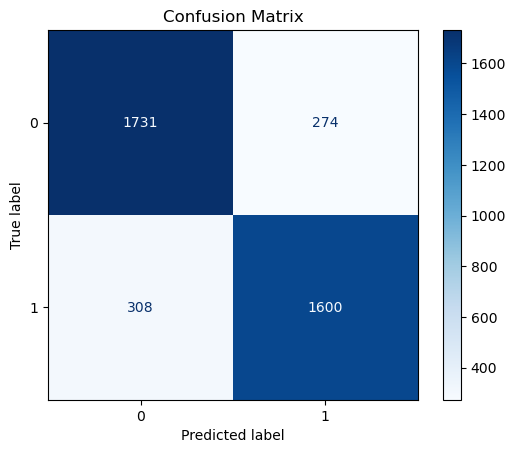

In [254]:

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

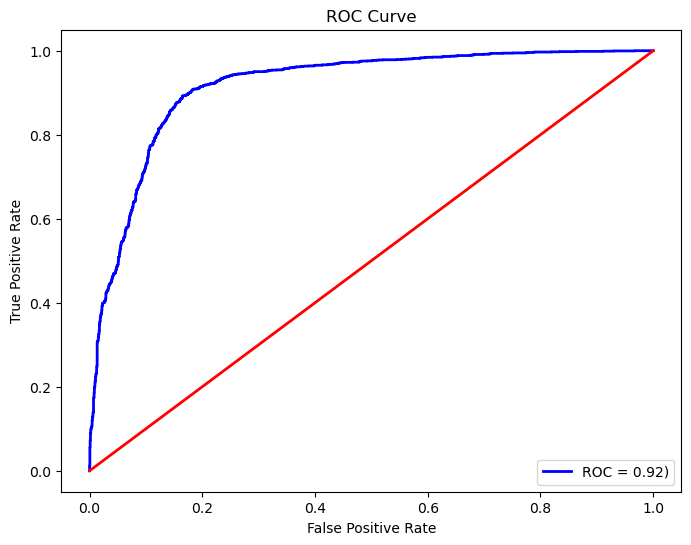

In [255]:

yPredProb = model.predict_proba(X_test)[:, 1] 

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, yPredProb)  # calculating false positive rate and true positive rate
AreaUnderCurve = auc(fpr, tpr)  # Calculating Area Under the Curve

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC = {AreaUnderCurve:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='-', lw=2) 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [256]:
nb_model = MultinomialNB()

# Train model
nb_model.fit(X_train, y_train)

# Make predictions
y_pred_nb = nb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 85.13%

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.86      0.86      2005
           1       0.85      0.84      0.85      1908

    accuracy                           0.85      3913
   macro avg       0.85      0.85      0.85      3913
weighted avg       0.85      0.85      0.85      3913



/Users/tinkuacchu/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [340]:
model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

/Users/tinkuacchu/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 95.20%

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.92      0.95      2005
           1       0.92      0.99      0.95      1908

    accuracy                           0.95      3913
   macro avg       0.95      0.95      0.95      3913
weighted avg       0.95      0.95      0.95      3913



In [338]:
xgb_model = xgb.XGBClassifier(use_label_encoder=True, eval_metric='logloss', random_state=32)
# Train model
xgb_model.fit(X_train, y_train)
# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

/Users/tinkuacchu/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:55:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 96.35%

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96      2005
           1       0.96      0.96      0.96      1908

    accuracy                           0.96      3913
   macro avg       0.96      0.96      0.96      3913
weighted avg       0.96      0.96      0.96      3913

